# Обучение EfficientNet для классификации фруктов и овощей

In [1]:
import zipfile
import os
import gdown
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR

In [2]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

TEMP_DIR = os.path.join(os.getcwd(), "temp")
TEMP_TRAIN_DIR = os.path.join(TEMP_DIR, "train")
TEMP_TEST_DIR = os.path.join(TEMP_DIR, "test")

ZIP_PATH = os.path.join(DRIVE_DIR, "dataset_32_classes_splitted.zip")
os.makedirs(DATASET_DIR, exist_ok=True)

Mounted at /content/drive


In [3]:
file_id = "1-1ehpRd0TnwB1hTHQbFHzdf55SrIri4f"
if os.path.exists(ZIP_PATH):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}", os.path.join(os.getcwd(), "dataset_32_classes.zip"), quiet=False
    )
zip_name = "dataset_32_classes.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1-1ehpRd0TnwB1hTHQbFHzdf55SrIri4f
From (redirected): https://drive.google.com/uc?id=1-1ehpRd0TnwB1hTHQbFHzdf55SrIri4f&confirm=t&uuid=393c53e7-b199-42a0-a090-c8a31db69997
To: /content/dataset_32_classes.zip
100%|██████████| 609M/609M [00:04<00:00, 127MB/s] 


In [4]:
with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall("./dataset")

## Подготовка данных и методов

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Отображу изображения, измененные с помощью transform

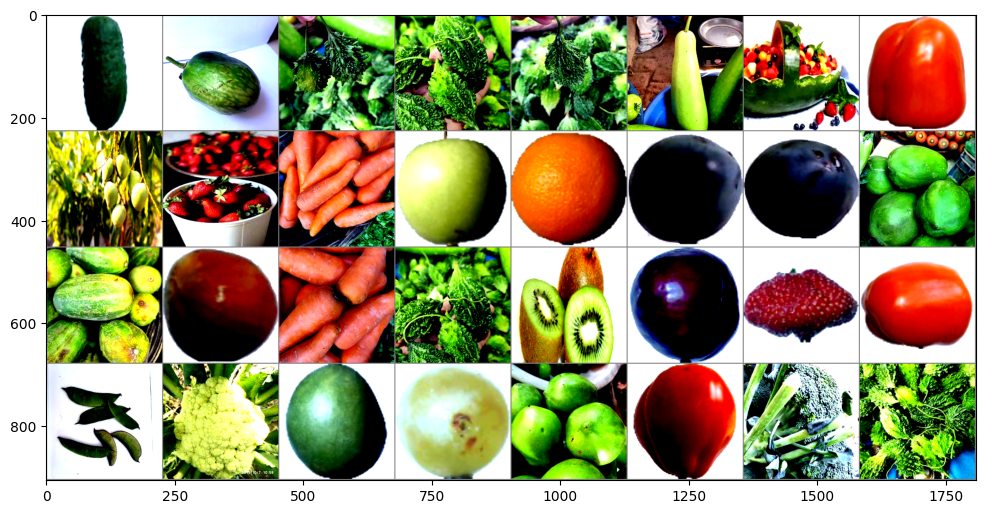

In [9]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [10]:
def plot_history(train_loss_log, val_loss_log, train_acc_log, val_acc_log):

    steps_loss = list(
        range(0, len(train_loss_log) + 1, int(len(train_loss_log) / len(val_loss_log)))
    )[1:]
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_log, label='train')
    plt.scatter(
        steps_loss, val_loss_log, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel('step')
    plt.ylabel('Loss')
    plt.title('Accuracy vs step')
    plt.grid()
    plt.legend()

    steps_acc = list(
        range(0, len(train_acc_log) + 1, int(len(train_acc_log) / len(val_acc_log)))
    )[1:]
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_log, label='train')
    plt.scatter(
        steps_acc, val_acc_log, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel('step')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs step')
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        y_pred = model(data.to(device))
        loss = criterion(y_pred, target.to(device))

        loss_log.append(loss.item())

        acc = (torch.argmax(y_pred, axis=1) == target.to(device)).sum() / target.to(device).shape[0]

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        y_pred = model(data.to(device))
        loss = criterion(y_pred, target.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.item())

        acc = (torch.argmax(y_pred, axis=1) == target.to(device)).sum() / target.to(device).shape[0]

        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [12]:
def create_model(num_classes, pretrained=True):

    model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT if pretrained else None)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(model.classifier[1].in_features, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, num_classes)
    )

    return model

model = create_model(num_classes=len(train_data.classes)).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


## Обучение модели

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, 5, train_loader, test_loader, scheduler)

Epoch 0
 train loss: 0.2360731292370474, train acc: 0.937890625
 val loss: 0.061226733222022545, val acc: 0.9827008928571429

Epoch 1
 train loss: 0.09779344090119203, train acc: 0.9723214285714286
 val loss: 0.07276942996073765, val acc: 0.9792410714285714

Epoch 2
 train loss: 0.07347992826739105, train acc: 0.9790736607142857
 val loss: 0.08429853386841424, val acc: 0.9802455357142857

Epoch 3
 train loss: 0.06015735484693973, train acc: 0.9822265625
 val loss: 0.054772515297120045, val acc: 0.9853794642857143

Epoch 4
 train loss: 0.05717446229743603, train acc: 0.9831752232142857
 val loss: 0.04336148807848001, val acc: 0.9881696428571428



In [14]:
_, acc_test = test(model, test_loader)
print(f"Точность на тестовой выборке = {acc_test}")

Точность на тестовой выборке = 0.9881696428571428


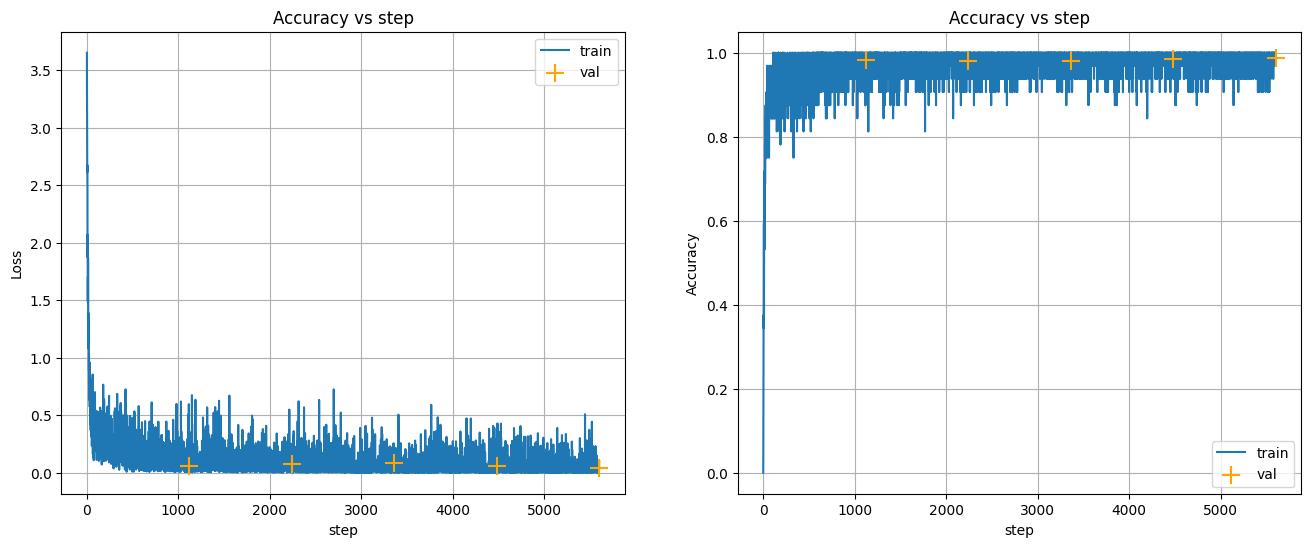

In [15]:
plot_history(train_loss_log, val_loss_log,train_acc_log, val_acc_log)

Сохраним веса обученной модели

In [16]:
torch.save(model.state_dict(), 'efficientnet_weights.pth')

## Вывод  
Была использована модель подобно EfficientNet с весами для ImageNet. Стандартный классификатор модели EfficientNet был заменён на кастомный блок:


---


Dropout -> Linear(256) -> ReLU -> BatchNorm1d -> Linear(num_classes)

---



Для обучения использовался **MultiStepLR-scheduler** с параметрами **milestones=[10, 15]** и **gamma=0.1**, позволяющий поэтапно уменьшать скорость обучения.


Полученные метрики:  
- train loss: 0.05717446229743603
- train acc: 0.9831752232142857
- val loss: 0.04336148807848001
- val acc: 0.9881696428571428